In [62]:
# by Grossmend, 2018

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, KFold

from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


## <b><font color='3C89F9'>1. Data preparation</font></b>

In [2]:
# train data
train_data = pd.read_csv('/kaggle/input/train.csv')

# test data
test_data = pd.read_csv('/kaggle/input/test.csv')

# concat train and test data in one DataFrame with keys
all_data = pd.concat([train_data, test_data], keys=['train', 'test'], axis=0, sort=False)

# set option display number columns
pd.set_option('display.max_columns', train_data.shape[1])

# show first 10 row data
all_data.head(7)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
      1   2          20       RL         80.0     9600   Pave   NaN      Reg   
      2   3          60       RL         68.0    11250   Pave   NaN      IR1   
      3   4          70       RL         60.0     9550   Pave   NaN      IR1   
      4   5          60       RL         84.0    14260   Pave   NaN      IR1   
      5   6          50       RL         85.0    14115   Pave   NaN      IR1   
      6   7          20       RL         75.0    10084   Pave   NaN      Reg   

        LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
train 0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
      1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
      2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
      3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
      4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
      5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
      6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   

        Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
train 0       Norm     1Fam     2Story            7            5       2003   
      1       Norm     1Fam     1Story            6            8       1976   
      2       Norm     1Fam     2Story            7            5       2001   
      3       Norm     1Fam     2Story            7            5       1915   
      4       Norm     1Fam     2Story            8            5       2000   
      5       Norm     1Fam     1.5Fin            5            5       1993   
      6       Norm     1Fam     1Story            8            5       2004   

         YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
train 0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
      1          1976     Gable  CompShg     MetalSd     MetalSd       None   
      2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
      3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
      4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
      5          1995     Gable  CompShg     VinylSd     VinylSd       None   
      6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   

         MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
train 0       196.0        Gd        TA      PConc       Gd       TA   
      1         0.0        TA        TA     CBlock       Gd       TA   
      2       162.0        Gd        TA      PConc       Gd       TA   
      3         0.0        TA        TA     BrkTil       TA       Gd   
      4       350.0        Gd        TA      PConc       Gd       TA   
      5         0.0        TA        TA       Wood       Gd       TA   
      6       186.0        Gd        TA      PConc       Ex       TA   

        BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
train 0           No          GLQ       706.0          Unf         0.0   
      1           Gd          ALQ       978.0          Unf         0.0   
      2           Mn          GLQ       486.0          Unf         0.0   
      3           No          ALQ       216.0          Unf         0.0   
      4           Av          GLQ       655.0          Unf         0.0   
      5           No          GLQ       732.0          Unf         0.0   
      6           Av          GLQ      1369.0          Unf         0.0   

         BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
train 0      150.0        856.0    GasA        Ex          Y      SBrkr   
      1      284.0       1262.0    GasA        Ex          Y      SBrkr   
      2      434.0        920.0    GasA        Ex          Y      SBrkr   
      3      54

In [3]:
# view size datasets
print('Size train_data:', all_data.loc['train'].shape)
print('Size test data:', all_data.loc['test'].shape)

Size train_data: (1460, 81)
Size test data: (1459, 81)


In [4]:
# view missing data in train and test data by percentage
nan_values = pd.concat([(train_data.isnull().sum() /  train_data.isnull().count())*100,
                        (test_data.isnull().sum() / test_data.isnull().count())*100], axis=1, keys=['Train', 'Test'], sort=False)
print('true')
nan_values[nan_values.sum(axis=1) > 0].sort_values(by=['Train'], ascending=False)

true


,Train,Test
PoolQC,99.520548,99.794380
MiscFeature,96.301370,96.504455
Alley,93.767123,92.666210
Fence,80.753425,80.123372
FireplaceQu,47.260274,50.034270
LotFrontage,17.739726,15.558602
GarageType,5.547945,5.209047
GarageCond,5.547945,5.346127
GarageYrBlt,5.547945,5.346127
GarageFinish,5.547945,5.346127


In [5]:
# view info without 'SalePrices'
all_data[all_data.columns.difference(['SalePrice'])].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (train, 0) to (test, 1458)
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Ext

In [6]:
# show counts each types in data
all_data.get_dtype_counts()

float64    12
int64      26
object     43
dtype: int64

In [7]:
# check duplecated field "id"
any(all_data['Id'].duplicated())

False

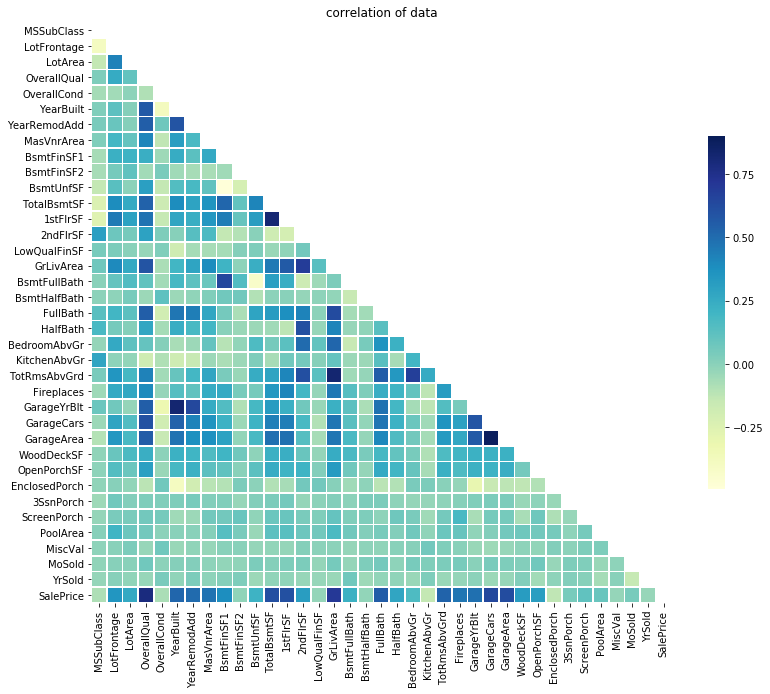

In [8]:
# show correlation of data
corrmat = train_data.drop('Id', axis=1).corr()
plt.subplots(figsize=(13,13))
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrmat, mask=mask, vmax=0.9, cmap="YlGnBu", square=True, cbar_kws={"shrink": .5}, linewidths=0.6);
plt.title('correlation of data');

# more settings: 'https://seaborn.pydata.org/generated/seaborn.heatmap.html'

In [9]:
# show most correlated features from field 'SalePrice'
corr=train_data.corr()["SalePrice"]
corr[np.argsort(corr, axis=0)[::-1]]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [10]:
# show descriptive statistics summary field "SalePrice"
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

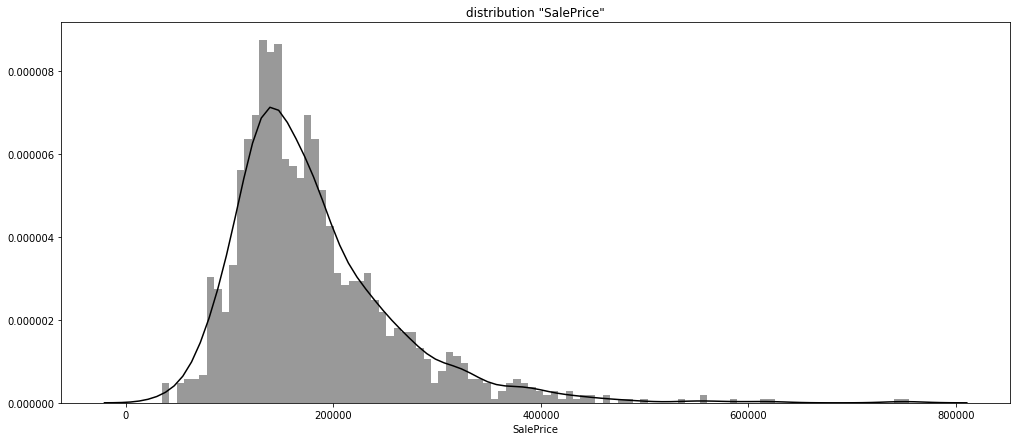

In [11]:
# show distribution field 'SalePrice'
plt.subplots(figsize=(17,7));
sns.distplot(train_data['SalePrice'], color='black', bins=100);
plt.title('distribution "SalePrice"');

In [12]:
# show skewness and kurtosis (показатели ассиметрии и аксцесса)
print('Skewness:', train_data['SalePrice'].skew())
print('Kurtosis:', train_data['SalePrice'].kurt())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


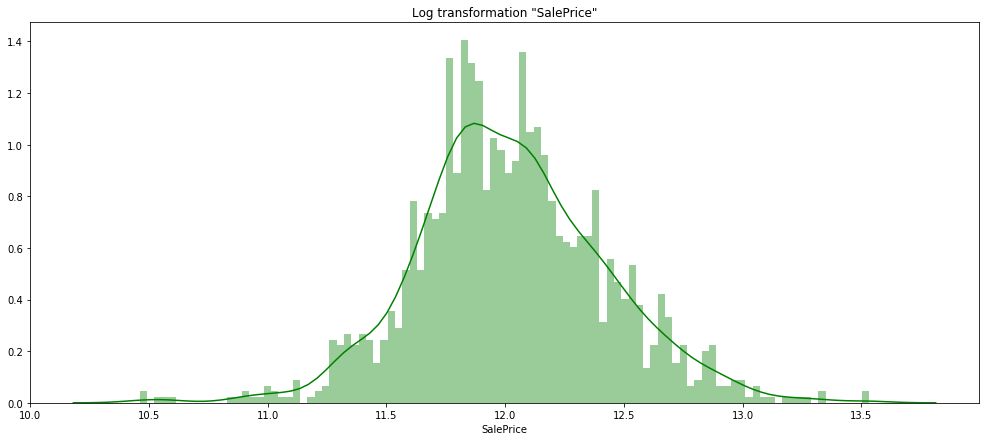

In [13]:
# log transformation of train labels (SalePrice)
train_labels = np.log(train_data['SalePrice'])
plt.subplots(figsize=(17,7));
sns.distplot(train_labels, color='green', bins=100);
plt.title('Log transformation "SalePrice"');

In [14]:
# delete field "SalePrice" from data
if 'SalePrice' in all_data:
    all_data.drop('SalePrice', inplace=True, axis=1)
else:
    print('no field "SalePrice"')
all_data.shape

(2919, 80)

In [15]:
# delete do not need fields (another analysis, see more: https://blog.grossmend.com/blog)

drop_list = [
    '3SsnPorch',
    'BsmtFinSF1',
    'BsmtFinSF2', 
    'BsmtFullBath',
    'BsmtHalfBath',
    'BsmtUnfSF',
    'EnclosedPorch',
    'Fence',
    'Functional',
    'GarageArea',
    'GarageCond',
    'GarageYrBlt',
    'Heating',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscFeature',
    'MiscVal',
    'OpenPorchSF',
    'PoolArea',
    'PoolQC',
    'RoofMatl',
    'ScreenPorch',
    'Utilities',
    'WoodDeckSF',
]

all_data.drop(drop_list, axis=1, errors='ignore', inplace=True)
all_data.shape

(2919, 56)

In [16]:
# show data first 7 rows
all_data.head(7)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
train 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
      1   2          20       RL         80.0     9600   Pave   NaN      Reg   
      2   3          60       RL         68.0    11250   Pave   NaN      IR1   
      3   4          70       RL         60.0     9550   Pave   NaN      IR1   
      4   5          60       RL         84.0    14260   Pave   NaN      IR1   
      5   6          50       RL         85.0    14115   Pave   NaN      IR1   
      6   7          20       RL         75.0    10084   Pave   NaN      Reg   

        LandContour LotConfig LandSlope Neighborhood Condition1 Condition2  \
train 0         Lvl    Inside       Gtl      CollgCr       Norm       Norm   
      1         Lvl       FR2       Gtl      Veenker      Feedr       Norm   
      2         Lvl    Inside       Gtl      CollgCr       Norm       Norm   
      3         Lvl    Corner       Gtl      Crawfor       Norm       Norm   
      4         Lvl       FR2       Gtl      NoRidge       Norm       Norm   
      5         Lvl    Inside       Gtl      Mitchel       Norm       Norm   
      6         Lvl    Inside       Gtl      Somerst       Norm       Norm   

        BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
train 0     1Fam     2Story            7            5       2003   
      1     1Fam     1Story            6            8       1976   
      2     1Fam     2Story            7            5       2001   
      3     1Fam     2Story            7            5       1915   
      4     1Fam     2Story            8            5       2000   
      5     1Fam     1.5Fin            5            5       1993   
      6     1Fam     1Story            8            5       2004   

         YearRemodAdd RoofStyle Exterior1st Exterior2nd MasVnrType ExterQual  \
train 0          2003     Gable     VinylSd     VinylSd    BrkFace        Gd   
      1          1976     Gable     MetalSd     MetalSd       None        TA   
      2          2002     Gable     VinylSd     VinylSd    BrkFace        Gd   
      3          1970     Gable     Wd Sdng     Wd Shng       None        TA   
      4          2000     Gable     VinylSd     VinylSd    BrkFace        Gd   
      5          1995     Gable     VinylSd     VinylSd       None        TA   
      6          2005     Gable     VinylSd     VinylSd      Stone        Gd   

        ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
train 0        TA      PConc       Gd       TA           No          GLQ   
      1        TA     CBlock       Gd       TA           Gd          ALQ   
      2        TA      PConc       Gd       TA           Mn          GLQ   
      3        TA     BrkTil       TA       Gd           No          ALQ   
      4        TA      PConc       Gd       TA           Av          GLQ   
      5        TA       Wood       Gd       TA           No          GLQ   
      6        TA      PConc       Ex       TA           Av          GLQ   

        BsmtFinType2  TotalBsmtSF HeatingQC CentralAir Electrical  1stFlrSF  \
train 0          Unf        856.0        Ex          Y      SBrkr       856   
      1          Unf       1262.0        Ex          Y      SBrkr      1262   
      2          Unf        920.0        Ex          Y      SBrkr       920   
      3          Unf        756.0        Gd          Y      SBrkr       961   
      4          Unf       1145.0        Ex          Y      SBrkr      1145   
      5          Unf        796.0        Ex          Y      SBrkr       796   
      6          Unf       1686.0        Ex          Y      SBrkr      1694   

         2ndFlrSF  GrLivArea  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
train 0       854       1710         2         1             3             1   
      1         0       1262         2         0             3             1   
      2       866       1786         2         1             3             

In [17]:
# show missing values each field
nan_values = pd.concat([(all_data.isnull().sum() /  all_data.isnull().count())*100], axis=1, keys=['all_data'], sort=False)
nan_values[nan_values.sum(axis=1) > 0].sort_values(by=['all_data'], ascending=False)

,all_data
Alley,93.216855
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageFinish,5.447071
GarageType,5.378554
BsmtCond,2.809181
BsmtExposure,2.809181
BsmtQual,2.774923
BsmtFinType2,2.740665


In [18]:
# missing nan values
if all_data.isnull().values.any():
    all_data['Alley'] = all_data['Alley'].fillna('no_access')
    all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('no_fp')
    all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].mean())
    all_data['MasVnrType'] = all_data['MasVnrType'].fillna(all_data['MasVnrType'].mode()[0])
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
    if 'TotalBsmtSF' in all_data:
        all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['GarageCars'] = all_data['GarageCars'].fillna(0.0)
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    for col in ('GarageType', 'GarageFinish', 'GarageQual'): all_data[col] = all_data[col].fillna('no_garage') 
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'): all_data[col] = all_data[col].fillna('no_bsmt')
else:
    print('all values is not missing')

In [19]:
# add need columns and drop do not need columns after missing
if set(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']).issubset(all_data.columns):
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
else:
    print("no found fields ('TotalBsmtSF', '1stFlrSF', '2ndFlrSF')")

In [20]:
# view missing data in train and test data by percentage
nan_values = pd.concat([(all_data.isnull().sum() /  all_data.isnull().count())*100], axis=1, keys=['all_data'], sort=False)
nan_values = nan_values[nan_values.sum(axis=1) > 0]
if nan_values.shape[0] > 0:
    nan_values.sort_values(by=['all_data'], ascending=False)
else:
    print('no missing values')

no missing values


In [21]:
# convert fields to categorical
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['KitchenAbvGr'] = all_data['KitchenAbvGr'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [22]:
# getting number fields from object
for col in all_data.dtypes[all_data.dtypes == 'object'].index:
    all_data[col] = all_data[col].astype('category')
    all_data[col] = all_data[col].cat.codes

In [23]:
# delete "Id" field
all_data = all_data.drop('Id', axis=1)

In [24]:
# normalize all values
all_data=(all_data-all_data.mean())/all_data.std()
print(all_data.shape)
all_data.head(7)

(2919, 53)


MSSubClass  MSZoning  LotFrontage   LotArea    Street     Alley  \
train 0    0.774807 -0.042149    -0.202033 -0.217841  0.064238  0.257239   
      1   -0.577053 -0.042149     0.501785 -0.072032  0.064238  0.257239   
      2    0.774807 -0.042149    -0.061269  0.137173  0.064238  0.257239   
      3    1.045179 -0.042149    -0.436639 -0.078371  0.064238  0.257239   
      4    0.774807 -0.042149     0.689469  0.518814  0.064238  0.257239   
      5    0.504435 -0.042149     0.736390  0.500430  0.064238  0.257239   
      6   -0.577053 -0.042149     0.267179 -0.010665  0.064238  0.257239   

         LotShape  LandContour  LotConfig  LandSlope  Neighborhood  \
train 0  0.746541     0.316616   0.588455  -0.216223     -1.248262   
      1  0.746541     0.316616  -0.658061  -0.216223      1.940732   
      2 -1.381539     0.316616   0.588455  -0.216223     -1.248262   
      3 -1.381539     0.316616  -1.904577  -0.216223     -1.080420   
      4 -1.381539     0.316616  -0.658061  -0.216223      0.430156   
      5 -1.381539     0.316616   0.588455  -0.216223     -0.241211   
      6  0.746541     0.316616   0.588455  -0.216223      1.437206   

         Condition1  Condition2  BldgType  HouseStyle  OverallQual  \
train 0   -0.046250   -0.009815 -0.419102    1.031544     0.646073   
      1   -1.190353   -0.009815 -0.419102   -0.536725    -0.063174   
      2   -0.046250   -0.009815 -0.419102    1.031544     0.646073   
      3   -0.046250   -0.009815 -0.419102    1.031544     0.646073   
      4   -0.046250   -0.009815 -0.419102    1.031544     1.355319   
      5   -0.046250   -0.009815 -0.419102   -1.582238    -0.772420   
      6   -0.046250   -0.009815 -0.419102   -0.536725     1.355319   

         OverallCond  YearBuilt  YearRemodAdd  RoofStyle  Exterior1st  \
train 0    -0.507197   1.046078      0.896679  -0.482843     0.742660   
      1     2.187904   0.154737     -0.395536  -0.482843    -0.507708   
      2    -0.507197   0.980053      0.848819  -0.482843     0.742660   
      3    -0.507197  -1.859033     -0.682695  -0.482843     1.055252   
      4    -0.507197   0.947040      0.753100  -0.482843     0.742660   
      5    -0.507197   0.715952      0.513801  -0.482843     0.742660   
      6    -0.507197   1.079091      0.992399  -0.482843     0.742660   

         Exterior2nd  MasVnrType  ExterQual  ExterCond  Foundation  BsmtQual  \
train 0     0.750206   -1.266934  -0.755664   0.376396    0.834475 -0.312225   
      1    -0.657877    0.384777   0.668341   0.376396   -0.540925 -0.312225   
      2     0.750206   -1.266934  -0.755664   0.376396    0.834475 -0.312225   
      3     1.313439    0.384777   0.668341   0.376396   -1.916324  0.771467   
      4     0.750206   -1.266934  -0.755664   0.376396    0.834475 -0.312225   
      5     0.750206    0.384777   0.668341   0.376396    4.960674 -0.312225   
      6     0.750206    2.036488  -0.755664   0.376396    0.834475 -2.479609   

         BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
train 0  0.234214      0.584181     -0.454731      0.281949  -0.880174   
      1  0.234214     -1.153184     -1.528648      0.281949  -0.880174   
      2  0.234214     -0.284502     -0.454731      0.281949  -0.880174   
      3 -2.620357      0.584181     -1.528648      0.281949   0.267571   
      4  0.234214     -2.021867     -0.454731      0.281949  -0.880174   
      5  0.234214      0.584181     -0.454731      0.281949  -0.880174   
      6  0.234214     -2.021867     -0.454731      0.281949  -0.880174   

         CentralAir  Electrical  GrLivArea  FullBath  HalfBath  BedroomAbvGr  \
train 0    0.268244    0.300563   0.413476  0.781232  1.232388      0.169898   
      1    0.268244    0.300563  -0.471810  0.781232 -0.756191      0.169898   
      2    0.268244    0.300563   0.563659  0.781232  1.232388      0.169898   
      3    0.268244    0.300563   0.427309 -1.027187 -0.756191      0.169898   
      4    0.268244    0.300563   1.377806  0.781232  1.232

In [25]:
# split dataset train data and test data for ML
X_model = all_data.loc['train'].select_dtypes(include=[np.number])
y_model = np.log(train_data['SalePrice'])

Y_finish = all_data.loc['test'].select_dtypes(include=[np.number])

In [26]:
# split data train and test
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.15)

## <b><font color='3C89F9'>2. Machine Learning</font></b>

### <b><font color='green'>Deep Learning</font> by Keras</b>

In [236]:
def build_model(insh):
    
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(insh,)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='sigmoid'))
    model.add(layers.Dense(1))
    
    opt = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    
    return model

In [241]:
# fit NN model
input_shape = X_train.shape[1]
DL_model = build_model(input_shape)

# get initial weights model
initial_weights = DL_model.get_weights()

history = DL_model.fit(X_train.values,
                       y_train.values,
                       epochs=300,
                       batch_size=128,
                       verbose=0,
                       validation_data=(X_test, y_test))

In [242]:
# check scores model
DL_model.evaluate(X_test.values, y_test.values)

219/219 [==============================] - 0s 78us/step


[0.019776845980248495, 0.09815805674143578]

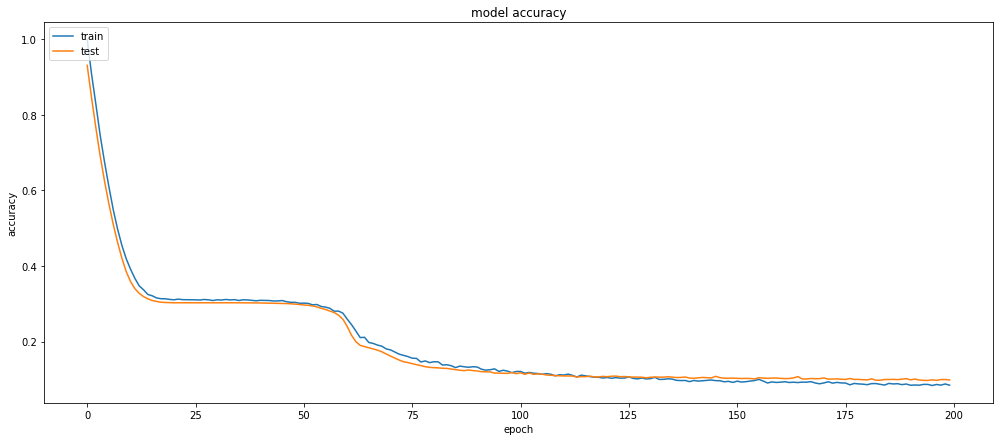

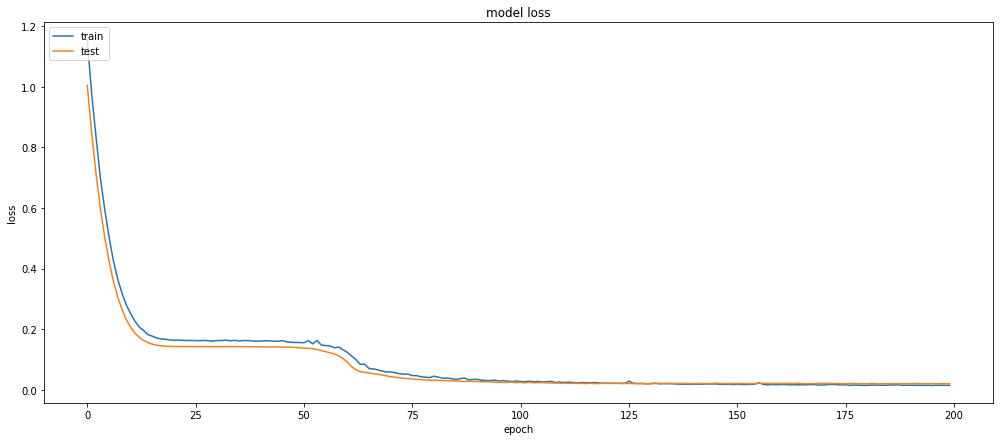

In [246]:
n = 50

plt.subplots(figsize=(17,7));
plt.plot(history.history['mean_absolute_error'][n:])
plt.plot(history.history['val_mean_absolute_error'][n:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.subplots(figsize=(17,7));
plt.plot(history.history['loss'][n:])
plt.plot(history.history['val_loss'][n:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [166]:
# # kross k validation

# kfold = KFold(n_splits=5, shuffle=True)

# scores = []

# nn_model = None
# nn_model = build_model(X_model.shape[1])

# for _ in range(5):
#     shf = shuffle(X_model, y_model)
#     for train, test in kfold.split(shf[0].reset_index(drop=True), shf[1].reset_index(drop=True)):
#         nn_model.set_weights(initial_weights)
#         nn_model.fit(X_model.iloc[train].values,
#                      y_model.iloc[train].values,
#                      epochs=300,
#                      batch_size=128,
#                      verbose=0)
#         acc = nn_model.evaluate(X_model.iloc[test].values, y_model.iloc[test].values, verbose=0)[1]
#         scores.append(acc)
#         print('accuracy step ' + str(len(scores)) + ': ', acc)
# print('mean:', np.mean(scores))    

In [247]:
# create finish model and train on complete train data
input_shape = X_model.shape[1]
DL_model_finish = build_model(input_shape)
DL_model_finish.set_weights(initial_weights)

DL_model_finish.fit(X_model.values,
                    y_model.values,
                    epochs=300,
                    batch_size=128,
                    verbose=0)

In [248]:
# get finish predict values
prediction = np.exp(DL_model_finish.predict(Y_finish.values))

In [249]:
# save to CSV
pd.DataFrame({'Id': test_data['Id'], 'SalePrice': prediction.flatten()}).to_csv('submission_nn_keras.csv', index=False)

### <b><font color='green'>GradientBoostingRegressor</font> by Scikit-learn</b>

In [66]:
# create model "GradientBoostingRegressor"
GBR = ensemble.GradientBoostingRegressor(loss='huber',
                                         learning_rate=0.07,
                                         n_estimators=300,
                                         max_depth=3,
                                         alpha=0.9,
                                         max_features='sqrt').fit(X_train, y_train)

print('train:', str(GBR.score(X_train.values, y_train.values)))
print('test:', str(GBR.score(X_test.values, y_test.values)))

train: 0.9599581607321023
test: 0.8681376935317545


In [67]:
# cross k validation
scores = cross_val_score(GBR, X_train.values, y_train.values, cv=5)
print('mean:', str(round(scores.mean(),3)), '\nstd:', str(round(scores.std()*2,3)))
print('scores cross k:', np.round(scores,3))
print('result: ~', 1-scores.mean()+scores.std()*2)

mean: 0.907 
std: 0.04
scores cross k: [0.933 0.904 0.914 0.872 0.911]
result: ~ 0.13299554842734748


In [68]:
# create finish model and train on complete train data
GBR_model_finish = GBR.fit(X_model.values, y_model.values)

In [69]:
# get finish predict values
finish_labels = np.exp(GBR_model_finish.predict(Y_finish.values))

In [70]:
# save to CSV
pd.DataFrame({'Id': test_data['Id'], 'SalePrice': finish_labels}).to_csv('submission_gbr.csv', index=False)